In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(img, time):
    cv2.imshow("frame: ", img)
    cv2.waitKey(time)
    cv2.destroyAllWindows()



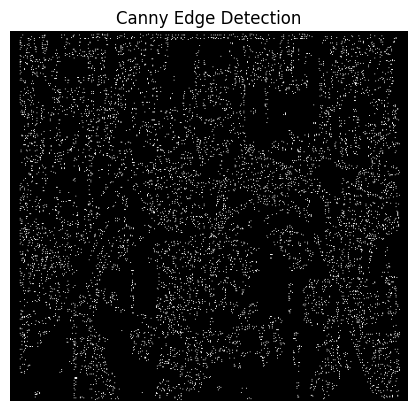

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Sobel Kernels
sobel_x = np.array([[-1, 0, 1], 
                    [-2, 0, 2], 
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1], 
                    [0, 0, 0], 
                    [1, 2, 1]])

# Non-Maximum Suppression
def non_max_supression(grad_mag, grad_dir):
    output = np.zeros_like(grad_mag, dtype=np.float32)
    h, w = grad_mag.shape
    angle = grad_dir * (180 / np.pi)
    angle[angle < 0] += 180

    for i in range(1, h - 1):
        for j in range(1, w - 1):
            current_angle = angle[i, j]
            q, r = 255, 255  # Default values if no edge
            
            if (0 <= current_angle < 22.5) or (157.5 <= current_angle <= 180):
                q = grad_mag[i, j + 1]
                r = grad_mag[i, j - 1]
            elif 22.5 <= current_angle < 67.5:
                q = grad_mag[i + 1, j - 1]
                r = grad_mag[i - 1, j + 1]
            elif 67.5 <= current_angle < 112.5:
                q = grad_mag[i + 1, j]
                r = grad_mag[i - 1, j]
            elif 112.5 <= current_angle < 157.5:
                q = grad_mag[i - 1, j - 1]
                r = grad_mag[i + 1, j + 1]

            if grad_mag[i, j] >= q and grad_mag[i, j] >= r:
                output[i, j] = grad_mag[i, j]
    return output

# Hysteresis Thresholding
def hysteresis_thresholding(img, high_thresh, low_thresh):
    high_thresh = np.max(img) * (high_thresh / 255.0)
    low_thresh = high_thresh * (low_thresh / 255.0)

    strong_edges = img >= high_thresh
    weak_edges = (img < high_thresh) & (img >= low_thresh)

    output = np.zeros_like(img, np.uint8)
    output[strong_edges] = 255
    output[weak_edges] = 75

    return output

# Edge Completion
def edge_completion(img):
    strong_edges = img == 255
    weak_edges = img == 75

    h, w = img.shape
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            if weak_edges[i, j] and np.any(strong_edges[i - 1:i + 2, j - 1:j + 2]):
                img[i, j] = 255
            else:
                img[i, j] = 0
    return img

# Main Function
def giveCanny(img):
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    gradient_x = cv2.filter2D(blur, ddepth=-1, kernel=sobel_x)
    gradient_y = cv2.filter2D(blur, ddepth=-1, kernel=sobel_y)

    gradient_magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
    gradient_magnitude = np.uint8(np.clip(gradient_magnitude, 0, 255))

    grad_angle = np.arctan2(gradient_y, gradient_x)

    non_max = non_max_supression(gradient_magnitude, grad_angle)
    hyst_thresh = hysteresis_thresholding(non_max, 200, 100)
    edge_completed = edge_completion(hyst_thresh)

    plt.imshow(edge_completed, cmap='gray')
    plt.title("Canny Edge Detection")
    plt.axis('off')
    plt.show()

# Load and Apply Canny Edge Detection
img = cv2.imread('./images/batman.png', 0)  # Load image in grayscale
giveCanny(img)


In [17]:
#color segm
img = cv2.imread('./images/rainbow.jpg')
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  
lower = np.array([35,100,100])
upper = np.array([85,255,255])

mask1 = cv2.inRange(img_hsv, lower, upper)
segmented = cv2.bitwise_and(img_hsv, img_hsv, mask=mask1)

mask_rgb = cv2.cvtColor(mask1, cv2.COLOR_GRAY2BGR)
seg_rbg = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)

x = np.concatenate([img_hsv, seg_rbg])
show(x, 2000)


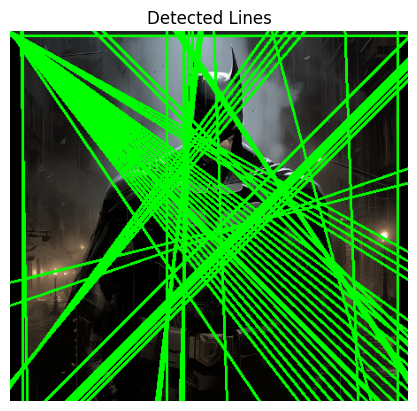

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def hough_transform(image, edge_image):
    # Define the Hough space dimensions
    rows, cols = edge_image.shape
    max_dist = int(np.hypot(rows, cols))
    theta = np.deg2rad(np.arange(-90, 90))  # Theta values from -90 to 90 degrees
    accumulator = np.zeros((2 * max_dist, len(theta)))  # Voting array

    # Find edge points
    y_idxs, x_idxs = np.nonzero(edge_image)

    # Voting in Hough space
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(len(theta)):
            rho = int(x * np.cos(theta[t_idx]) + y * np.sin(theta[t_idx])) + max_dist
            accumulator[rho, t_idx] += 1

    return accumulator, theta

def detect_lines(accumulator, theta, threshold):
    lines = []
    max_dist = accumulator.shape[0] // 2

    # Threshold the accumulator to detect lines
    for r in range(accumulator.shape[0]):
        for t in range(accumulator.shape[1]):
            if accumulator[r, t] > threshold:
                rho = r - max_dist
                theta_val = theta[t]
                lines.append((rho, theta_val))
    return lines

def draw_lines(image, lines):
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Lines")
    plt.axis("off")
    plt.show()

# Read and preprocess the image
image = cv2.imread('./images/batman.png')  # Replace with your image path
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)  # Detect edges using Canny

# Perform Hough Transform
accumulator, theta = hough_transform(image, edges)

# Detect lines with a voting threshold
lines = detect_lines(accumulator, theta, threshold=100)  # Adjust threshold based on image

# Draw the detected lines
draw_lines(image, lines)


In [41]:
image = cv2.imread('./images/road.png')  

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 50, 150, apertureSize=3) #applying canny
#The apertureSize parameter in the cv2.Canny() function specifies the size of the Sobel kernel used for finding image gradients. 

show(edges, 100)

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 45, minLineLength=10, maxLineGap=200)
print(lines)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2, = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0,255,0), 2)
    
show(image, 2000)
        

[[[221   1 349 198]]

 [[232   7 370 204]]

 [[226   1 353 182]]

 [[239   0 401 179]]

 [[210  10 298 200]]

 [[245   2 398 171]]

 [[204   0 291 204]]

 [[  0 134 106   3]]

 [[211   1 313 202]]

 [[238   0 400 179]]

 [[224   7 357 197]]

 [[173   9 183 204]]

 [[226   0 368 202]]

 [[  6 117  96  20]]

 [[274  32 399 171]]

 [[ 21  49  78   1]]

 [[ 71 184 141   1]]

 [[ 39  57  95   0]]

 [[ 66 184 140   1]]

 [[  2  51  70   0]]

 [[172  16 178 204]]

 [[  1 123 123   1]]

 [[204   1 276 170]]

 [[211   0 315 204]]

 [[221   0 351 185]]

 [[219   2 360 204]]

 [[270   2 392 100]]

 [[  0  42  61   0]]

 [[  1  89  56  41]]

 [[  0  49  54   9]]

 [[267  52 377 204]]

 [[  5   1 389   1]]

 [[ 11 112 116   0]]]


[903.]
Starting threshold:  100
m1, m2:  97.8 169.53752786516387
New threshold:  133
Starting threshold:  133
m1, m2:  115.7433097837722 191.71502633359813
New threshold:  153
Starting threshold:  153
m1, m2:  121.18987399147856 197.65066687753702
New threshold:  159
No updates required.
Final threshold: 159


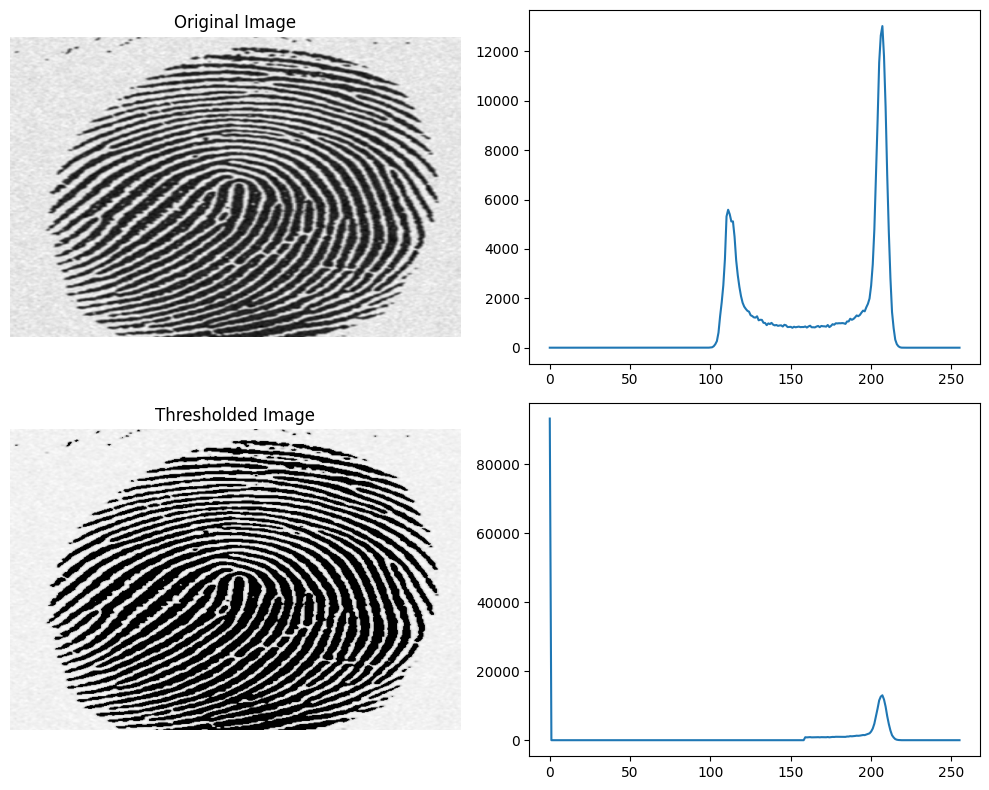

In [46]:
#global thresholding
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read and resize the image
img = cv2.imread('./images/globalthresh.png', 0)
img = cv2.resize(img, (600, 400))
orig = img.copy()  # Create a copy for displaying the original image

# Calculate the histogram
histg_c = cv2.calcHist([img], [0], None, [256], [0, 256])
print(histg_c[140])

def global_thresholding(histg_c, starting_thres):
    print("Starting threshold: ", starting_thres)

    # Flatten histogram
    histg_c = histg_c.flatten()

    # Compute class sums and counts
    below_threshold_count = np.sum(histg_c[:starting_thres])
    above_threshold_count = np.sum(histg_c[starting_thres:])

    # Avoid division by zero
    if below_threshold_count == 0 or above_threshold_count == 0:
        print("No pixels in one of the classes.")
        return starting_thres

    below_threshold_sum = np.sum(np.arange(starting_thres) * histg_c[:starting_thres])
    above_threshold_sum = np.sum(np.arange(starting_thres, 256) * histg_c[starting_thres:])

    # Calculate means
    m1 = below_threshold_sum / below_threshold_count
    m2 = above_threshold_sum / above_threshold_count

    print("m1, m2: ", m1, m2)

    # Calculate new threshold
    new_t = int((m1 + m2) / 2)
    print("New threshold: ", new_t)

    if abs(new_t - starting_thres) < 10:
        print('No updates required.')
        return new_t
    else:
        return global_thresholding(histg_c, new_t)  # Return the result of the recursive call

# Initialize the thresholding
initial_threshold = 100
final_T = global_thresholding(histg_c, initial_threshold)

print("Final threshold:", final_T)

# Apply thresholding to the image
thresholded_img = np.where(img < final_T, 0, img)  # Use np.where for efficiency

# Plot the original and thresholded images
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

thresh_hist = cv2.calcHist([thresholded_img], [0], None, [256], [0,256])

axs[0, 0].imshow(orig, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0,0].axis('off')

axs[0,1].plot(histg_c)

axs[1, 0 ].imshow(thresholded_img, cmap='gray')
axs[1, 0].set_title('Thresholded Image')
axs[1, 0].axis('off')

axs[1,1].plot(thresh_hist)

plt.tight_layout()
plt.show()

In [66]:
import cv2
import numpy as np

# Load image in grayscale mode
img = cv2.imread('./images/globalthresh.png', 0)

# Function to compute histogram of the image
def getHisto(img):
    histo = np.zeros(256, np.float32)  # Fix: Use 256 instead of 255
    h, w = img.shape[0], img.shape[1]
    for i in range(h):
        for j in range(w):
            histo[img[i][j]] += 1
    return histo

# Otsu's global thresholding implementation
def otsu_global(img):
    hist = getHisto(img)
    total_pixels = img.size
    curr_max_bw_class = 0
    thresh_val = 0

    sum_p_k = np.sum(np.arange(256) * hist)  # Fix: Use 256 instead of 255
    sum_p_1 = 0  # Sum of background class intensities
    num_bg, num_fg = 0, 0  # Pixel counts for background and foreground

    # Iterate over all possible threshold values
    for t in range(256):
        num_bg += hist[t]
        if num_bg == 0:
            continue
        num_fg = total_pixels - num_bg
        if num_fg == 0:
            break

        sum_p_1 += t * hist[t]  # Fix: Use += instead of *=
        sum_p_2 = sum_p_k - sum_p_1

        # Calculate means of the two classes
        m1 = sum_p_1 / num_bg
        m2 = sum_p_2 / num_fg

        # Calculate between-class variance
        bw_class_var = num_fg * num_bg * (m1 - m2) ** 2
        if bw_class_var > curr_max_bw_class:
            curr_max_bw_class = bw_class_var
            thresh_val = t

    return thresh_val

# Calculate threshold using Otsu's method
thresh = otsu_global(img)

# Function to perform segmentation based on threshold
def otsu_segmentation(thresh, img):
    # Set pixels below the threshold to 0
    img[img < thresh] = 0
    # Set pixels equal to or above the threshold to 255
    img[img >= thresh] = 255
    # Display the segmented image
    cv2.imshow('Segmented Image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Perform segmentation using the calculated threshold
otsu_segmentation(thresh, img)
